In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from helper import plot_anomalies
from Dataset import DatasetLoader
from pyanomaly.stats import MAD, Tukey
from pyanomaly.timeseries import moving_average, moving_average_score, \
                                    twitter, twitter_score

In [3]:
loader = DatasetLoader()
#loader.print_all()

In [4]:
ds_names = loader.get_list('realKnownCause')
ds_names

['ambient_temperature_system_failure.csv',
 'cpu_utilization_asg_misconfiguration.csv',
 'ec2_request_latency_system_failure.csv',
 'machine_temperature_system_failure.csv',
 'nyc_taxi.csv',
 'rogue_agent_key_hold.csv',
 'rogue_agent_key_updown.csv']

## Preprocessamento

In [5]:
df_raw, labels = loader.load('ec2_request_latency_system_failure.csv')
df_raw.head()

,value
timestamp,
2014-03-07 03:41:00,45.868
2014-03-07 03:46:00,47.606
2014-03-07 03:51:00,42.580
2014-03-07 03:56:00,46.030
2014-03-07 04:01:00,44.992


Valores **duplicados** e **missing data**

In [6]:
df_raw.index.duplicated().sum()

11

In [7]:
df_raw[df_raw.index.duplicated()]

,value
timestamp,
2014-03-09 03:00:00,43.578
2014-03-09 03:00:00,47.018
2014-03-09 03:00:00,46.456
2014-03-09 03:00:00,44.368
2014-03-09 03:00:00,43.544
2014-03-09 03:00:00,44.938
2014-03-09 03:00:00,43.834
2014-03-09 03:00:00,47.026
2014-03-09 03:00:00,42.368


In [8]:
df_raw['2014-03-09 02:00:00':'2014-03-09 02:59:00']

,value
timestamp,


In [9]:
df = df_raw.resample('5min').mean()

In [10]:
df.isnull().sum()

value    13
dtype: int64

In [11]:
df.fillna(method='ffill', inplace=True)

In [12]:
df.index.min(), df.index.max(), df.shape

(Timestamp('2014-03-07 03:40:00', freq='5T'),
 Timestamp('2014-03-21 03:40:00', freq='5T'),
 (4033, 1))

In [13]:
pd.date_range(start=df_raw.index.min(), end=df_raw.index.max(), freq='5T')

DatetimeIndex(['2014-03-07 03:41:00', '2014-03-07 03:46:00',
               '2014-03-07 03:51:00', '2014-03-07 03:56:00',
               '2014-03-07 04:01:00', '2014-03-07 04:06:00',
               '2014-03-07 04:11:00', '2014-03-07 04:16:00',
               '2014-03-07 04:21:00', '2014-03-07 04:26:00',
               ...
               '2014-03-21 02:56:00', '2014-03-21 03:01:00',
               '2014-03-21 03:06:00', '2014-03-21 03:11:00',
               '2014-03-21 03:16:00', '2014-03-21 03:21:00',
               '2014-03-21 03:26:00', '2014-03-21 03:31:00',
               '2014-03-21 03:36:00', '2014-03-21 03:41:00'],
              dtype='datetime64[ns]', length=4033, freq='5T')

**Visualização**

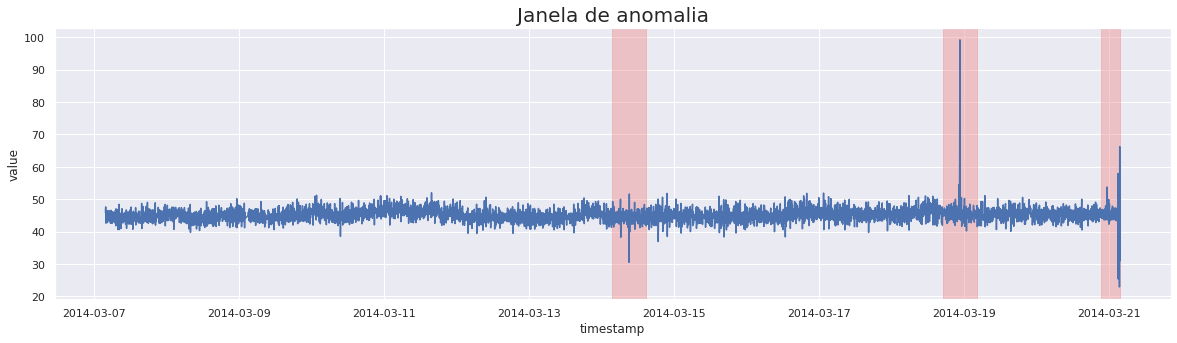

In [40]:
plot_anomalies(df_raw['value'], windows=labels)

plt.title("Janela de anomalia",fontsize=20);

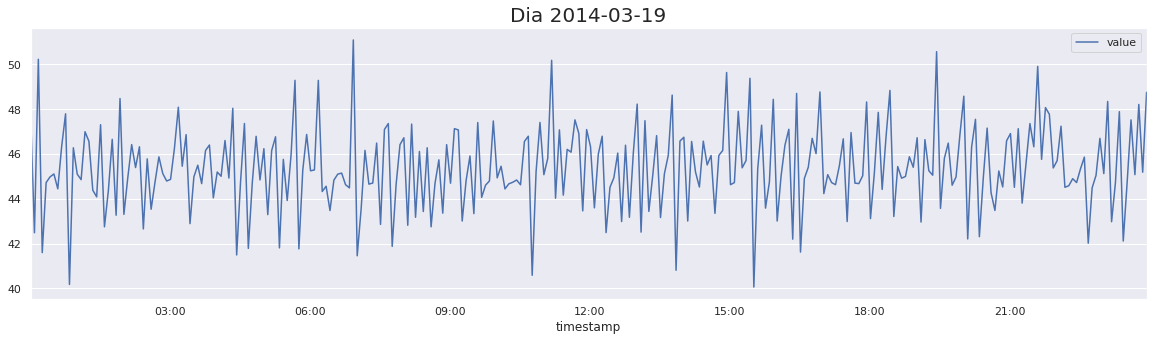

In [25]:
df_raw['2014-03-19'].plot(figsize=(20, 5))
plt.title('Dia 2014-03-19', fontsize=20);

## Algoritmos

### MAD

In [35]:
ts = df_raw['value']

In [36]:
mad = MAD()
mad.fit(ts)
madpredict = mad.predict(ts)
madpredict.head()

timestamp
2014-03-10 01:06:00    50.906
2014-03-10 01:36:00    51.198
2014-03-10 09:31:00    38.498
2014-03-10 22:46:00    50.992
2014-03-10 22:56:00    50.938
Name: value, dtype: float64

In [42]:
# score por dia
mad_dayscore = madpredict.resample('1H').count().dropna()/12

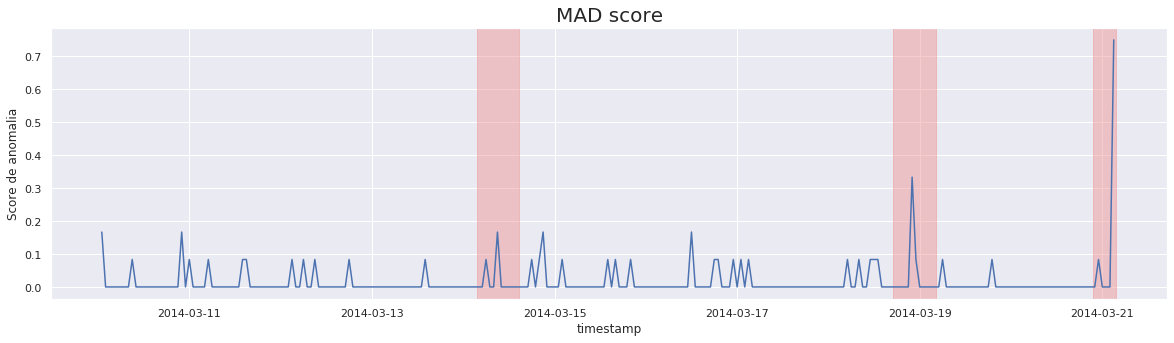

In [43]:
plot_anomalies(mad_dayscore, windows=labels)

plt.title("MAD score",fontsize=20)
plt.ylabel('Score de anomalia');

### Tukey

In [44]:
ts = df_raw['value']

In [45]:
tu = Tukey()
tu.fit(ts)
tupredict = tu.predict(ts)
tupredict.head()

timestamp
2014-03-08 07:51:00    39.718
2014-03-08 10:51:00    40.306
2014-03-08 23:11:00    50.140
2014-03-09 19:11:00    50.070
2014-03-10 01:06:00    50.906
Name: value, dtype: float64

In [46]:
tu_dayscore = tupredict.resample('1H').count().dropna()/12

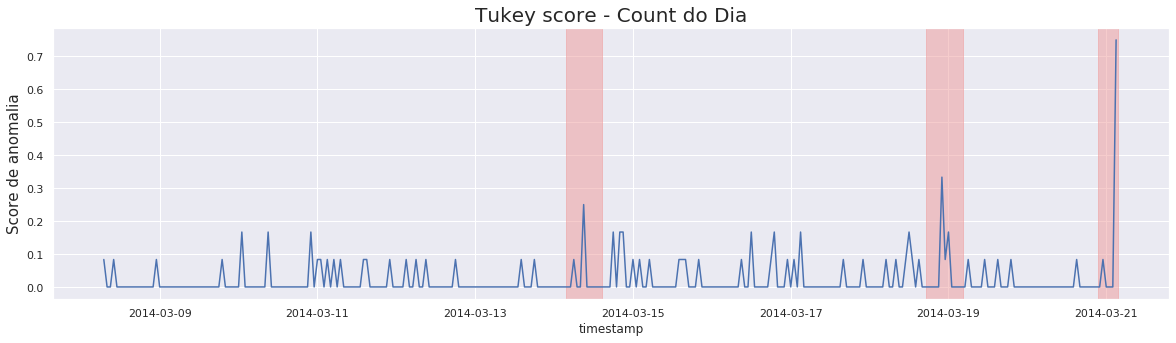

In [47]:
plot_anomalies(tu_dayscore, windows=labels)
plt.title("Tukey score - Count do Dia",fontsize=20)
plt.ylabel('Score de anomalia', fontsize=15);

### Twitter

In [61]:
ts = df_raw['value']

In [66]:
ts.resample('1H').count()

timestamp
2014-03-07 03:00:00     4
2014-03-07 04:00:00    12
2014-03-07 05:00:00    12
2014-03-07 06:00:00    12
2014-03-07 07:00:00    12
                       ..
2014-03-20 23:00:00    12
2014-03-21 00:00:00    12
2014-03-21 01:00:00    12
2014-03-21 02:00:00    12
2014-03-21 03:00:00     9
Freq: H, Name: value, Length: 337, dtype: int64

In [62]:
twitterpredict = twitter(ts, period=12)
twitterpredict.head()

timestamp
2014-03-10 01:06:00    50.906
2014-03-10 01:36:00    51.198
2014-03-10 09:26:00    50.212
2014-03-10 09:31:00    38.498
2014-03-10 15:31:00    49.622
Name: value, dtype: float64

In [67]:
twitter_dayscore = twitterpredict.resample('1H').count().dropna()/12

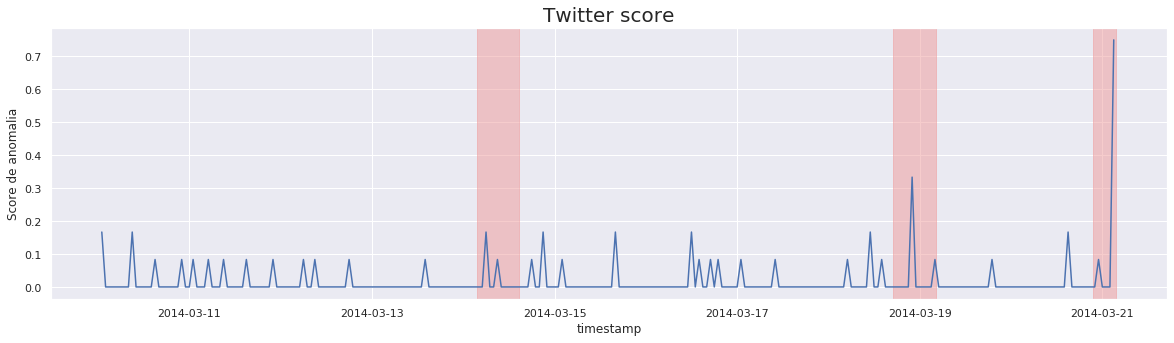

In [68]:
plot_anomalies(twitter_dayscore, windows=labels)
plt.title("Twitter score",fontsize=20)
plt.ylabel('Score de anomalia');

### Forecast

#### ARIMA

In [ ]:
#TODO

#### Holt-Winters

In [22]:
#TODO

## Comparação por rank

In [56]:
from helper import top_k_precision, plot_precision_recall_curve

### Resample

In [57]:
# Calculando top k precision para cada tecnica
mad_topk = top_k_precision(mad_dayscore, labels, k=5)
tu_topk = top_k_precision(tu_dayscore, labels, k=5)
twitter_topk = top_k_precision(twitter_dayscore, labels, k=5)

df_topk = pd.DataFrame({'mad': mad_topk,
                        'tukey': tu_topk,
                        'twitter': twitter_topk},
                        index=np.arange(1, 6))
df_topk

,mad,tukey,twitter
1,1.000000,1.00,1.000000
2,1.000000,1.00,1.000000
3,0.666667,1.00,0.666667
4,0.750000,0.75,0.500000
5,0.600000,0.60,0.400000


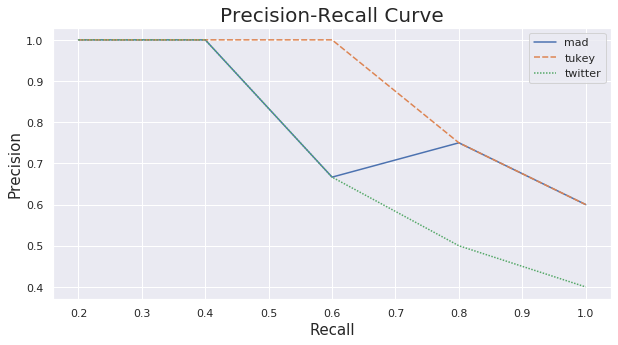

In [58]:
fig, ax = plot_precision_recall_curve(df_topk)

### Save

In [59]:
df_topk.index.names = ['rank']
df_topk.to_csv('./results/' + 'topk_score_' + ds_names[2])

In [60]:
fig.savefig('./results/' + 'topk_score_' + ds_names[2].split('.')[0] + '.jpg')